In [1]:
'''
The following uses the presidential election results by state to predict the
outcome by state for the specified election year. This is done using basic
linear regression.
'''

'\nThe following uses the presidential election results by state to predict the\noutcome by state for the specified election year. This is done using basic\nlinear regression.\n'

In [8]:
## Imports
from pres_polling_ewma import *
from my_info import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
## Filter the election results for dem and rep
parties = ['DEMOCRAT', 'REPUBLICAN']
pres_results_state_df = pres_results_state_df[pres_results_state_df['party_detailed'].isin(parties)]

# Merge polling and election results data on year, state and candidate name
merged_data = pd.merge(past_pres_avgs_df, pres_results_state_df, how='inner', on=['year', 'state', 'candidate'])

# drop unnecessary columns
drop_cols = ['state_po', 'state_fips', 'state_cen', 'state_ic', 'office', 'writein', 'version', 'notes', 'party_simplified', 'candidate_id', 'timestamp']
merged_data = merged_data.drop(columns=drop_cols)

# add and format columns
merged_data['cand_pct'] = merged_data['candidatevotes'] / merged_data['totalvotes']
merged_data['modeldate'] = pd.to_datetime(merged_data['modeldate'], format='%d-%m-%Y')
merged_data['election_date'] = pd.to_datetime(merged_data['election_date'], format='%d-%m-%Y')

# group the df by year, state, and candidate, and pick the most recent date for each group
# this is done since the model only needs the final poll data from each election to create the model
merged_data = merged_data.groupby(['year', 'state', 'candidate']).agg({'modeldate': 'max', **{col: 'first' for col in merged_data.columns if col not in ['year', 'state', 'candidate', 'date']}}).reset_index()


In [4]:
# Apply label encoding to relevant categorical columns in the original DataFrame
merged_data_encoded = merged_data.copy()
label_encoder = LabelEncoder()
merged_data_encoded['state_enc'] = label_encoder.fit_transform(merged_data_encoded['state'])
merged_data_encoded['party_detailed_enc'] = label_encoder.fit_transform(merged_data_encoded['party_detailed'])

# the year you want to predict
predict_yr = 2016

# Filter training data for years 1976 to predict_yr less 4
train_data = merged_data_encoded[(merged_data_encoded['year'] >= 1976) & (merged_data_encoded['year'] <= predict_yr - 4)]

# Initialize a dictionary to store predictions and evaluation metrics for each party
party_results = {}

# Group the training data by party
grouped_train_data = train_data.groupby('party_detailed_enc')

# Iterate over each party group
for party, group_data in grouped_train_data:
    # Select relevant columns
    relevant_columns = ['state_enc', 'pct_estimate', 'candidatevotes', 'totalvotes', 'cand_pct']
    X_train = group_data[relevant_columns[:-1]]  # Exclude 'cand_pct' which is the target variable
    y_train = group_data['cand_pct']

    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Filter test data for the party in 2012
    test_data_party = merged_data_encoded[(merged_data_encoded['year'] == predict_yr) & (merged_data_encoded['party_detailed_enc'] == party)]
    X_test_party = test_data_party[relevant_columns[:-1]]  # Exclude 'cand_pct' which is the target variable
    y_true_party = test_data_party['cand_pct']

    # Predict the 2012 election results for the party
    y_pred_party = model.predict(X_test_party)

    # Evaluate the model for the party
    mae_party = mean_absolute_error(y_true_party, y_pred_party)
    mse_party = mean_squared_error(y_true_party, y_pred_party)
    r2_party = r2_score(y_true_party, y_pred_party)

    # Store results for the party in the dictionary
    party_results[party] = {
        'y_pred': y_pred_party,
        'y_true': y_true_party,
        'mae': mae_party,
        'mse': mse_party,
        'r2': r2_party
    }

# Print or visualize results for each party
for party, results in party_results.items():
    print(f"\nParty: {party}")
    print("Predicted values for 2012 election:")
    print(results['y_pred'])
    print("\nTrue values for 2012 election:")
    print(results['y_true'])
    print("\nMean Absolute Error:", results['mae'])
    print("Mean Squared Error:", results['mse'])
    print("R-squared:", results['r2'])



Party: 0
Predicted values for 2012 election:
[0.37437413 0.46527645 0.44944222 0.4072351  0.8195329  0.46125391
 0.50279306 0.46541885 0.69264177 0.47992355 0.4443071  0.5158298
 0.39706027 0.50012083 0.40779946 0.4619644  0.41751622 0.35997156
 0.40552698 0.46266194 0.6116555  0.61269156 0.49245109 0.46434662
 0.45506516 0.40482853 0.40097947 0.40329393 0.46178624 0.48268656
 0.55585089 0.45708287 0.6330356  0.46507935 0.38186478 0.42616392
 0.36020874 0.4738265  0.48046514 0.46819165 0.44261324 0.39863178
 0.38733954 0.42103963 0.36981618 0.45530456 0.51385815 0.5207442
 0.35683589 0.48925927 0.36009923]

True values for 2012 election:
889    0.343579
891    0.365509
893    0.451260
895    0.336531
897    0.617264
899    0.481570
901    0.545663
903    0.533533
905    0.904839
907    0.478233
909    0.456400
911    0.609808
913    0.274920
915    0.558254
917    0.377748
919    0.417525
921    0.360524
923    0.326822
925    0.384496
927    0.463452
929    0.603257
931    0.590501
9

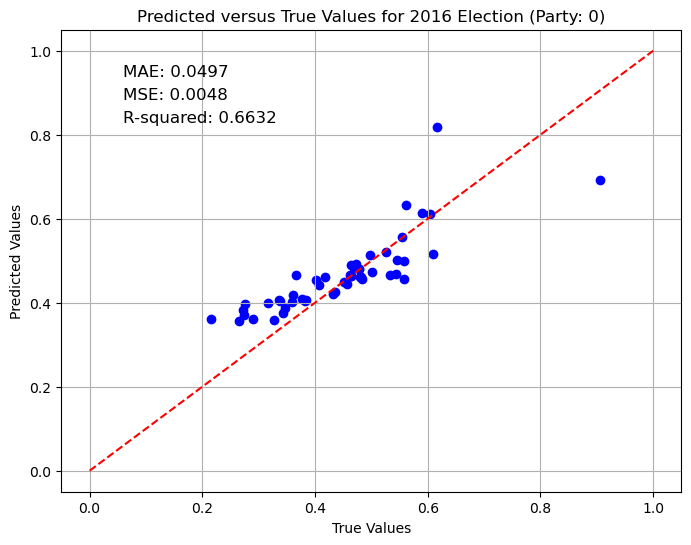

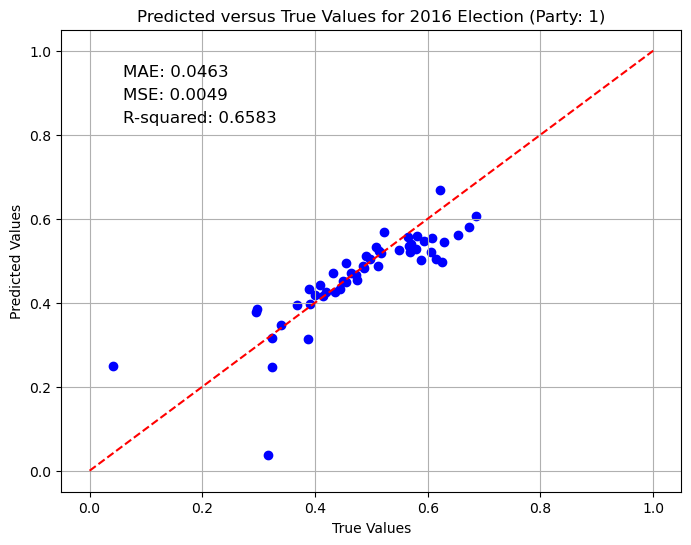

In [5]:
import matplotlib.pyplot as plt

# Function to plot true versus predicted values for a party
def plot_results(party, y_true, y_pred, mae, mse, r2):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Plot the 45-degree line
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted versus True Values for {predict_yr} Election (Party: {party})')
    plt.grid(True)
    plt.text(0.1, 0.9, f'MAE: {mae:.4f}', transform=plt.gca().transAxes, fontsize=12)
    plt.text(0.1, 0.85, f'MSE: {mse:.4f}', transform=plt.gca().transAxes, fontsize=12)
    plt.text(0.1, 0.8, f'R-squared: {r2:.4f}', transform=plt.gca().transAxes, fontsize=12)
    plt.show()

# Plot results for each party
for party, results in party_results.items():
    plot_results(party, results['y_true'], results['y_pred'], results['mae'], results['mse'], results['r2'])


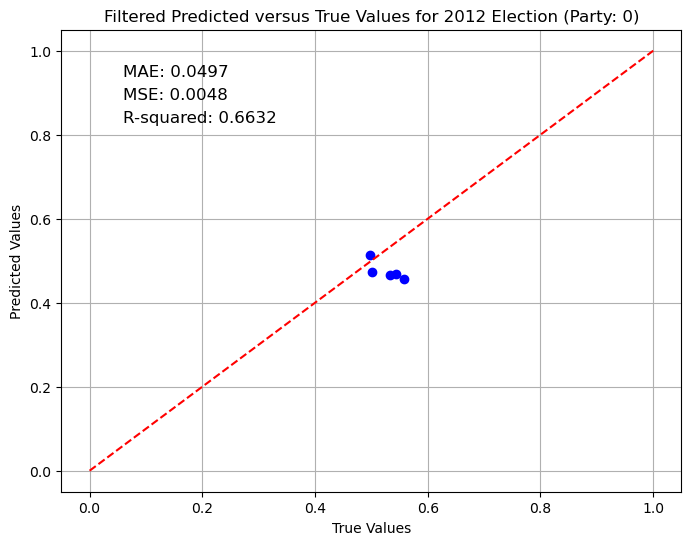

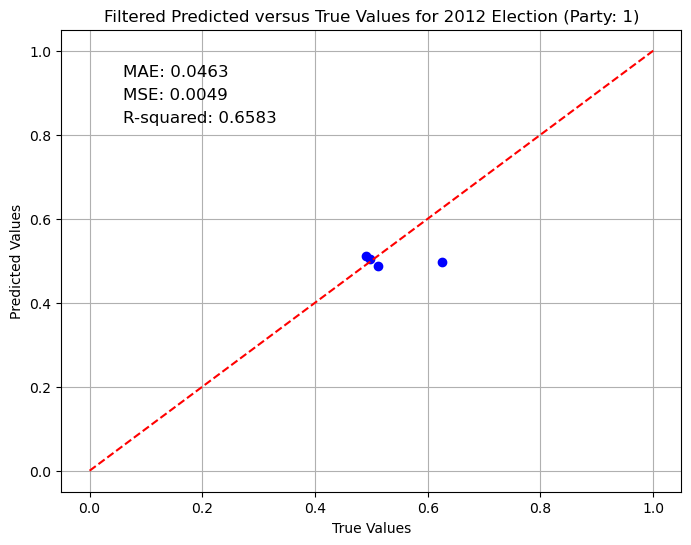

In [6]:
import numpy as np

# Function to plot filtered true versus predicted values for a party
def plot_filtered_results(party, y_true, y_pred, mae, mse, r2):
    # Filter data based on the condition
    condition = (y_true > 0.5) & (y_pred < 0.5) | (y_true < 0.5) & (y_pred > 0.5)
    filtered_y_true = y_true[condition]
    filtered_y_pred = y_pred[condition]

    # Plot filtered results
    plt.figure(figsize=(8, 6))
    plt.scatter(filtered_y_true, filtered_y_pred, color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Plot the 45-degree line
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Filtered Predicted versus True Values for 2012 Election (Party: {party})')
    plt.grid(True)
    plt.text(0.1, 0.9, f'MAE: {mae:.4f}', transform=plt.gca().transAxes, fontsize=12)
    plt.text(0.1, 0.85, f'MSE: {mse:.4f}', transform=plt.gca().transAxes, fontsize=12)
    plt.text(0.1, 0.8, f'R-squared: {r2:.4f}', transform=plt.gca().transAxes, fontsize=12)
#     plt.xlim([0.48, 0.585])
#     plt.ylim([0.47, 0.51])
    plt.show()

# Plot filtered results for each party
for party, results in party_results.items():
    plot_filtered_results(party, results['y_true'], results['y_pred'], results['mae'], results['mse'], results['r2'])


In [7]:
res = pd.DataFrame()
for party, results in party_results.items():
    print(f"Party: {party}")
    ytrue = pd.DataFrame(results['y_true'])
    ytrue.reset_index(drop=True, inplace=True)
    
    print("Predicted")
    print(pd.DataFrame(results['y_pred']))
    print("True")
    print(ytrue)

Party: 0
Predicted
           0
0   0.374374
1   0.465276
2   0.449442
3   0.407235
4   0.819533
5   0.461254
6   0.502793
7   0.465419
8   0.692642
9   0.479924
10  0.444307
11  0.515830
12  0.397060
13  0.500121
14  0.407799
15  0.461964
16  0.417516
17  0.359972
18  0.405527
19  0.462662
20  0.611655
21  0.612692
22  0.492451
23  0.464347
24  0.455065
25  0.404829
26  0.400979
27  0.403294
28  0.461786
29  0.482687
30  0.555851
31  0.457083
32  0.633036
33  0.465079
34  0.381865
35  0.426164
36  0.360209
37  0.473826
38  0.480465
39  0.468192
40  0.442613
41  0.398632
42  0.387340
43  0.421040
44  0.369816
45  0.455305
46  0.513858
47  0.520744
48  0.356836
49  0.489259
50  0.360099
True
    cand_pct
0   0.343579
1   0.365509
2   0.451260
3   0.336531
4   0.617264
5   0.481570
6   0.545663
7   0.533533
8   0.904839
9   0.478233
10  0.456400
11  0.609808
12  0.274920
13  0.558254
14  0.377748
15  0.417525
16  0.360524
17  0.326822
18  0.384496
19  0.463452
20  0.603257
21  0.590501
2